# Environment settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import random
from feret_utils import get_feret_files_and_tags_dict, run_face_detection, create_dataset, create_dataset_gs
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
from IPython.display import Image
import cv2 as cv
import tensorflow as tf
import scipy
from datetime import datetime
import pickle
tfe = tf.contrib.eager

In [2]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.12.0


# Import precreated pickle file with dataset info

In [3]:
import pickle
# Unpickle data_dict holding the training and evaluation examples after performing data augmentation and regulerization
with open('feret_data_dict_gs.pickle', 'rb') as handle:
    subject_list, data_dict, mean_image, std_image = pickle.load(handle)

# Class to manage dataset minibatch structures for comparisson test

In [4]:
# This class allows building "couples" for the purpose of npairs training.
# It samples for every minibatch a set of batch size couples with different labels.
class Dataset():
    def __init__(self, X_train, y_train, batch_size=100, num_of_epochs=10):
        self.batch_size = batch_size - (batch_size % 2)
        self.num_of_epochs = num_of_epochs
        self.X_train = X_train
        self.y_train = y_train
        
        # Hold a list of training examples we have not used yet which will be modified every time an example is used
        self.unused_y = list(range(len(y_train)))
        self.steps = int((X_train.shape[0] * self.num_of_epochs) / self.batch_size)
    
    def create_mini_batch(self):
        mini_X_train = np.zeros((self.batch_size, 96, 96, 1), dtype=np.float32)
        mini_y_train = np.zeros((self.batch_size))
        
        # Verify there are enough examples left in dataset to fill minibatch, if not reset list of unused examples
        if len(self.unused_y) < self.batch_size:
            self.unused_y = list(range(len(self.y_train)))
        half_batch = int(self.batch_size/2)
        used_y = []
        for i in range(half_batch):
            chosen=False
            while(not chosen):
                pos = random.choice(self.unused_y)
                if (self.y_train[pos] in used_y):
                    continue
                mini_X_train[i] = self.X_train[pos]
                mini_y_train[i] = self.y_train[pos]
                if (pos != 6930) and (self.y_train[pos] == self.y_train[pos+1]):
                    mini_X_train[i+half_batch] = self.X_train[pos+1]
                    mini_y_train[i+half_batch] = self.y_train[pos+1]
                    chosen = True
                elif (pos != 0) and (self.y_train[pos] == self.y_train[pos-1]):
                    mini_X_train[i+half_batch] = self.X_train[pos-1]
                    mini_y_train[i+half_batch] = self.y_train[pos-1]
                    chosen = True
            
            # Once we used an exqmple, remove it from the 
            self.unused_y.remove(pos)
            used_y.append(self.y_train[pos])
        
        return mini_X_train, mini_y_train

# Classifier model working with 2 steps of training, classification and npairs. The model will then be used to extract a feature layer which will be compared with other layers.

In [ ]:
class CombinedClassifier(tf.keras.Model):
    def __init__(self, num_of_ids, loss_type="Class", similarity_threshold=5, class_lr=0.5*1e-4, sim_lr=1e-3):
        super().__init__()
        self.loss_type = loss_type
        self.similarity_threshold = similarity_threshold
        self.num_of_ids = num_of_ids
        self.flag_for_combined_loss = False
        
        # Conv layer 1 + Pooling
        self.conv1a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[4, 4],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool1a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 2 + Pooling
        self.conv2a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool2a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 3 + Pooling
        self.conv3a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool3a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Dense output layer, also used as a feature exxtrction layer
        self.fc1a = tf.keras.layers.Dense(1024, activation=None)
        self.fc1a_act = tf.keras.layers.Activation(activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        # Dense layer for classes
        self.fc2a = tf.keras.layers.Dense(num_of_ids)
        
        # Optimizers
        self.optimizer1 = tf.train.AdamOptimizer(learning_rate=class_lr)
        self.optimizer2 = tf.train.AdamOptimizer(learning_rate=sim_lr, beta1=0.85)
        
    def call(self, inputs, training=True, **kwargs):
        half_batch_size = int(int(inputs.shape[0]) / 2)
        batch_size = int(half_batch_size * 2)
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 96, 96, 1])
        
        # Network forward flow
        x1 = self.conv1a(input_layer)
        x1 = self.pool1a(x1)
        x1 = self.conv2a(x1)
        x1 = self.pool2a(x1)
        x1 = self.conv3a(x1)
        x1 = self.pool3a(x1)
        x1 = tf.reshape(x1, [x1.shape[0], -1])
        x1_id_layer = self.fc1a(x1)
        x1_id_layer_act = self.fc1a_act(x1_id_layer)
        
        # If we are training for classification loss, use dropout.
        if (training):
            if self.loss_type is "Class":
                x1_dropout = self.dropout(x1_id_layer_act)
                x1_logits = self.fc2a(x1_dropout)
            else:
                x1_logits = self.fc2a(x1_id_layer_act)
                
            # Get L2 distances between image "couples"
            distances = tf.reduce_mean((x1_id_layer[0:half_batch_size] - x1_id_layer[half_batch_size:batch_size])**2, axis=1)

        else:
            x1_logits = self.fc2a(x1_id_layer_act)
            distances = 0

        
        return x1_logits, x1_id_layer, distances 
    
    def loss(self, logits1, labels1, x1_id_layer, batch_size):        
        half_batch_size = int(batch_size / 2)
        
        # Just to make sure that both halves are equal
        batch_size = int(half_batch_size * 2)
        
        # Calculate losses according to classification requirments and comparison requirement
        # Loss 1: classification requirement
        onehot_labels = tf.one_hot(indices=tf.cast(labels1, tf.int32), depth = num_of_ids)
        loss_1 = tf.losses.softmax_cross_entropy(onehot_labels, logits1)
            
        # Loss 2: npairs loss
        gt_labels = tf.convert_to_tensor(labels1[0:half_batch_size])
        
        anchors = tf.convert_to_tensor(x1_id_layer[0:half_batch_size])
        positives = tf.convert_to_tensor(x1_id_layer[half_batch_size:batch_size])
        loss_2 = tf.contrib.losses.metric_learning.npairs_loss(labels=gt_labels,
                                                                    embeddings_anchor=anchors,
                                                                    embeddings_positive=positives,
                                                                    reg_lambda=1e-5)
        return loss_1, loss_2
    
    def optimize(self, inputs, labels):
        with tf.GradientTape(persistent=True) as tape:
            x1_logits, x1_id_layer, distances = self(inputs)
            loss_1, loss_2 = self.loss(x1_logits, labels, x1_id_layer, int(inputs.shape[0]))
        
        # Apply gradinets according totraining phase we are in
        if self.loss_type is "Class":
            gradients = tape.gradient(loss_1, self.variables)
            self.optimizer1.apply_gradients(zip(gradients, self.variables))
        if self.loss_type is "Similarity":
            # For similarity training apply gradients only to the fc1a layer
            gradients = tape.gradient(loss_2, self.variables[6:8])
            self.optimizer2.apply_gradients(zip(gradients, self.variables[6:8]))
            
        del(tape)
        return loss_1, loss_2
    
    def test(self, inputs, labels, similarity_test=False, training_set=False, debug_print=False, thresh=1):
        x1_logits, x1_id_layer, distance = self(inputs, training=False)
        test_class_1, test_class_2, test_compare = 0, 0, 0
        
        # Scores for predecting image labels
        pred_labels = tf.argmax(x1_logits, axis=-1)
        pred_labels = tf.cast(pred_labels, tf.float64)
        label_acc = tf.reduce_mean(tf.cast(tf.equal(pred_labels, labels), tf.float32))
        
        # Scores for the similarity test
        correct, incorrect = 0, 0
        similarity_acc = 0
        sum_of_distances_for_sim, sum_of_distances_for_diff, sim_count, diff_count = 0, 0, 0, 0
        sim_diff_ratio = 0
        
        size = int(inputs.shape[0]) if (int(inputs.shape[0]) % 2 == 0) else int(inputs.shape[0]) - 1
        
        if (similarity_test):
            # Training and validation set have different structures so testing method is split into 2 options
            if (training_set):
                for i in range(0, int(size/2)):
                    id_1 = tf.reshape(x1_id_layer[i], (1, 1024))
                    id_2 = tf.reshape(x1_id_layer[int(size/2) + i], (1024, 1))
                    score = np.tensordot(id_1, id_2)
                    if int(labels[i]) == int(labels[int(size/2) + i]):
                        if score > thresh:
                            correct +=1
                        else:
                            incorrect +=1
                    else:
                        if score < thresh:
                            correct +=1
                        else:
                            incorrect +=1
            else:
                for i in range(0, size, 2):
                    id_1 = tf.reshape(x1_id_layer[i], (1, 1024))
                    id_2 = tf.reshape(x1_id_layer[i + 1], (1, 1024))
                    score = np.tensordot(id_1, id_2)
                    if int(labels[i]) == int(labels[i + 1]):
                        sum_of_distances_for_sim += score
                        sim_count += 1
                        if score > thresh:
                            if(debug_print):
                                print("Got similar pics correct: score = {} thresh = {}".format(score, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got similar pics wrong: score = {} thresh = {}".format(score, thresh))
                            incorrect +=1
                    else:
                        sum_of_distances_for_diff += score
                        diff_count += 1
                        if score < thresh:
                            if(debug_print):
                                print("Got different pics correct: score = {} thresh = {}".format(score, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got different pics wrong: score = {} thresh = {}".format(score, thresh))
                            incorrect +=1
                distance_average_sim = sum_of_distances_for_sim/sim_count
                distance_average_diff = sum_of_distances_for_diff/diff_count
                # sim_diff_ratio is the ration of differences between distances predicted for similar pairs and the 
                # distacnes predicted for different pairs. The lower the difference the better the model will differ between
                # similar and different images
                sim_diff_ratio = distance_average_sim/distance_average_diff
                            
            # similarity_acc is the percantage of correct predictions
            similarity_acc = correct/(correct + incorrect)
            
        return label_acc, similarity_acc, sim_diff_ratio
        


# Phase 1: Train using classification loss

In [17]:
num_of_ids = len(subject_list)
# Metrics to save
loss1_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
best_score = 0

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 50
STEP_SIZE_EVALUATE = 100

batch_size = 250
num_of_epochs = 30

dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Class", class_lr=1e-3)
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):
            
            # Evaluate on validation set
            accuracy, _, _ = model.test(data_dict['X_eval'], data_dict['y_eval'])
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f" % (step, accuracy)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            if (accuracy > best_score):
                model.save_weights('cpt/cpt_%s' % step)
                name_save = ('cpt/cpt_%s' % step)
                best_score = accuracy
            
            # Evaluate on training set
            accuracy, _, _ = model.test(batch_x, batch_y)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f" % (step, accuracy)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
        # Train
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: classification loss: %f" % (step, loss1)))
        
    

[29.12|22:13:46] Step 0: classification loss: 6.555204
[29.12|22:13:54] Step 50: classification loss: 4.297305
[29.12|22:14:02] EVAL SET: Step 100: classification accuracy: 0.552239
[29.12|22:14:03] TRAIN SET: Step 100: classification accuracy: 0.712000
[29.12|22:14:03] Step 100: classification loss: 1.194985
[29.12|22:14:11] Step 150: classification loss: 0.264032
[29.12|22:14:19] EVAL SET: Step 200: classification accuracy: 0.649254
[29.12|22:14:20] TRAIN SET: Step 200: classification accuracy: 0.972000
[29.12|22:14:20] Step 200: classification loss: 0.117675
[29.12|22:14:28] Step 250: classification loss: 0.037147
[29.12|22:14:36] EVAL SET: Step 300: classification accuracy: 0.712687
[29.12|22:14:36] TRAIN SET: Step 300: classification accuracy: 1.000000
[29.12|22:14:37] Step 300: classification loss: 0.006358
[29.12|22:14:45] Step 350: classification loss: 0.001452
[29.12|22:14:53] EVAL SET: Step 400: classification accuracy: 0.723881
[29.12|22:14:53] TRAIN SET: Step 400: classific

## Classification loss

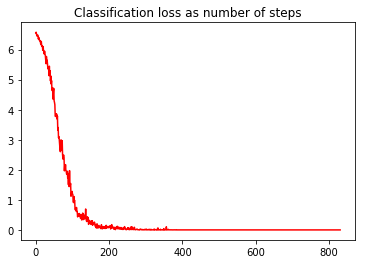

In [18]:
plot.title('Classification loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()

## Classification accuracy

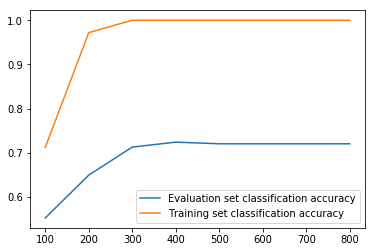

In [19]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()

In [43]:
def get_best_score(model):
    best_sim=0
    threshs = np.arange(1000, 10000, 500)
    for i in threshs:
        _, sim, _ = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=i)
        if (sim >= best_sim):
            best_sim = sim
            best_thresh = i
    return (best_sim, best_thresh)

# Phase 2: train using npairs loss

In [44]:
num_of_ids = len(subject_list)

#Metrics to save
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 100
STEP_SIZE_EVALUATE = 500
best_sim = 0

batch_size = 128
num_of_epochs = 200
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=100, sim_lr=1e-4)
    model.load_weights(name_save)
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):          
            # Evaluate on validation set
            sim, th = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_sim):
                model.save_weights('cpt/cpt_sim_npairs')
                best_sim = sim
                best_thresh = th       
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: npairs loss: %f" % (step, loss2)))


[29.12|22:44:35] Step 0: npairs loss: 12190.788086
[29.12|22:44:44] Step 100: npairs loss: 1627.297852
[29.12|22:44:53] Step 200: npairs loss: 969.502991
[29.12|22:45:02] Step 300: npairs loss: 872.321045
[29.12|22:45:12] Step 400: npairs loss: 451.049377
[29.12|22:45:23] EVAL SET: Step 500: similarity accuracy: 0.805970
[29.12|22:45:24] Step 500: npairs loss: 347.718628
[29.12|22:45:33] Step 600: npairs loss: 404.567871
[29.12|22:45:42] Step 700: npairs loss: 318.528137
[29.12|22:45:51] Step 800: npairs loss: 272.672302
[29.12|22:46:00] Step 900: npairs loss: 101.109329
[29.12|22:46:12] EVAL SET: Step 1000: similarity accuracy: 0.828358
[29.12|22:46:13] Step 1000: npairs loss: 91.435623
[29.12|22:46:22] Step 1100: npairs loss: 187.947372
[29.12|22:46:31] Step 1200: npairs loss: 206.297104
[29.12|22:46:40] Step 1300: npairs loss: 98.606743
[29.12|22:46:49] Step 1400: npairs loss: 40.728302
[29.12|22:47:01] EVAL SET: Step 1500: similarity accuracy: 0.820896
[29.12|22:47:01] Step 1500: n

In [47]:
model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=100)
model.load_weights('cpt/cpt_sim_npairs')
_, sim, ratio = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=best_thresh)
print("Summary for similarity: similarity accuracy = {}, sim diff ratio = {}".format(sim, 1/ratio))

Summary for similarity: similarity accuracy = 0.8507462686567164, sim diff ratio = 0.2870623970266448


## npairs Loss 

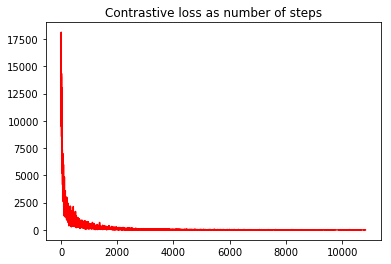

In [30]:
plot.title('Contrastive loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

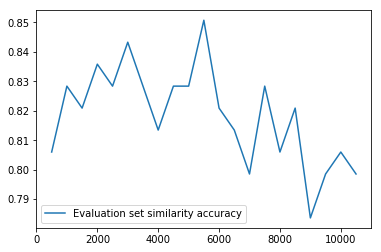

In [48]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.legend()
plot.show()

### Summary:accuracy=85.1%, sim diff ratio=0.28

### It looks like this model scores the best score, yet while training it is a bit not stable and seems at some point to overfit. In addition when running this in the app, we seem to get unstable results. This might be due to fine tuning requirments in the app. We might want to compare images to more than 1 photo in the app to give a smoother score.